# Label Flip Detection using Graph Manifold Methods

This notebook explores whether graph-based Laplacian smoothness scores can detect manually flipped labels in the Two Moons dataset.
We hypothesize that flipped labels will have high local variance (Dirichlet energy) relative to their neighbors.

In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve

# Add project root to path
notebook_dir = os.path.dirname(os.path.abspath(''))
if os.path.basename(notebook_dir) == 'notebooks':
    project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
else:
    project_root = notebook_dir

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data import generate_two_moons
from src.graph_manifold import compute_laplacian_smoothness_score
from src.utils import set_seed

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

## 1. Data Generation and Label Flipping

In [2]:
# Generate clean Two Moons dataset
n_samples = 1000
noise = 0.1
X_train, y_train_clean, _, _, _, _ = generate_two_moons(
    n_samples=n_samples,
    noise=noise,
    random_state=SEED
)

print(f"Generated {len(X_train)} training samples")

# Introduce label noise (flip labels)
flip_ratio = 0.10  # 10% label noise
n_flip = int(len(y_train_clean) * flip_ratio)

# Choose random indices to flip
np.random.seed(SEED)  # Ensure reproducibility of flips
flip_indices = np.random.choice(len(y_train_clean), n_flip, replace=False)

# Create noisy label vector
y_train_noisy = y_train_clean.copy()
y_train_noisy[flip_indices] = 1 - y_train_noisy[flip_indices]  # Flip 0->1, 1->0

# Create ground truth mask for flipped labels (1 = flipped, 0 = clean)
is_flipped = np.zeros(len(y_train_clean), dtype=int)
is_flipped[flip_indices] = 1

print(f"Flipped {n_flip} labels ({flip_ratio*100}%)")

Generated 600 training samples
Flipped 60 labels (10.0%)


## 2. Compute Graph Scores

We use the **Laplacian Smoothness Score** (Dirichlet energy increment). For a point $z$ with label $f(z)$, the score is:
$$ E(z) = \sum_{j \in \mathcal{N}(z)} w_{zj} (f(z) - f(x_j))^2 $$
where $\mathcal{N}(z)$ are the k-nearest neighbors and $w_{zj}$ are Gaussian weights.

A high score indicates that the point's label is different from its neighbors, suggesting it might be flipped or an outlier.

In [3]:
# Compute Laplacian scores for all training points
# We treat the noisy dataset as our "training set" and compute the score for each point relative to others

k_neighbors = 10
scores = np.zeros(len(X_train))

print("Computing scores...")
for i in range(len(X_train)):
    # Point under consideration
    z = X_train[i]
    f_z = y_train_noisy[i]
    
    # Remove the point itself from the reference set for k-NN to avoid self-loop bias
    # (Though compute_laplacian_smoothness_score finds neighbors in Z_train)
    # Ideally, we should use Leave-One-Out, but for k=10 in 1000 points, 
    # the effect of including self is minimal if nearest neighbor distance is small.
    # However, to be strict, let's pass the full set and rely on k-NN finding neighbors.
    # Note: compute_laplacian_smoothness_score will find z's neighbors in Z_train.
    # If z is in Z_train, it will be its own nearest neighbor with dist 0.
    # The implementation excludes self-connections in graph building but not explicitly in the score function's k-NN query.
    # Let's see if we need to adjust k. For standard LOO, we might want k+1 neighbors and ignore the first one.
    
    # Actually, the function 'compute_laplacian_smoothness_score' takes z and Z_train.
    # If z is exactly in Z_train, distances[0] will be 0.
    # Let's perform a mask to exclude self for cleaner "outlier" detection logic,
    # or just accept that one neighbor is self (consistent label -> 0 contribution).
    # Since (f(z) - f(z))^2 = 0, self-loops add 0 to the energy, so it's safe.
    
    scores[i] = compute_laplacian_smoothness_score(
        z=z,
        f_z=f_z,
        Z_train=X_train,
        f_train=y_train_noisy,
        k=k_neighbors
    )

print(f"Scores computed. Range: [{scores.min():.4f}, {scores.max():.4f}]")

Computing scores...
Scores computed. Range: [0.0000, 8.9908]


## 3. Visualization and Analysis

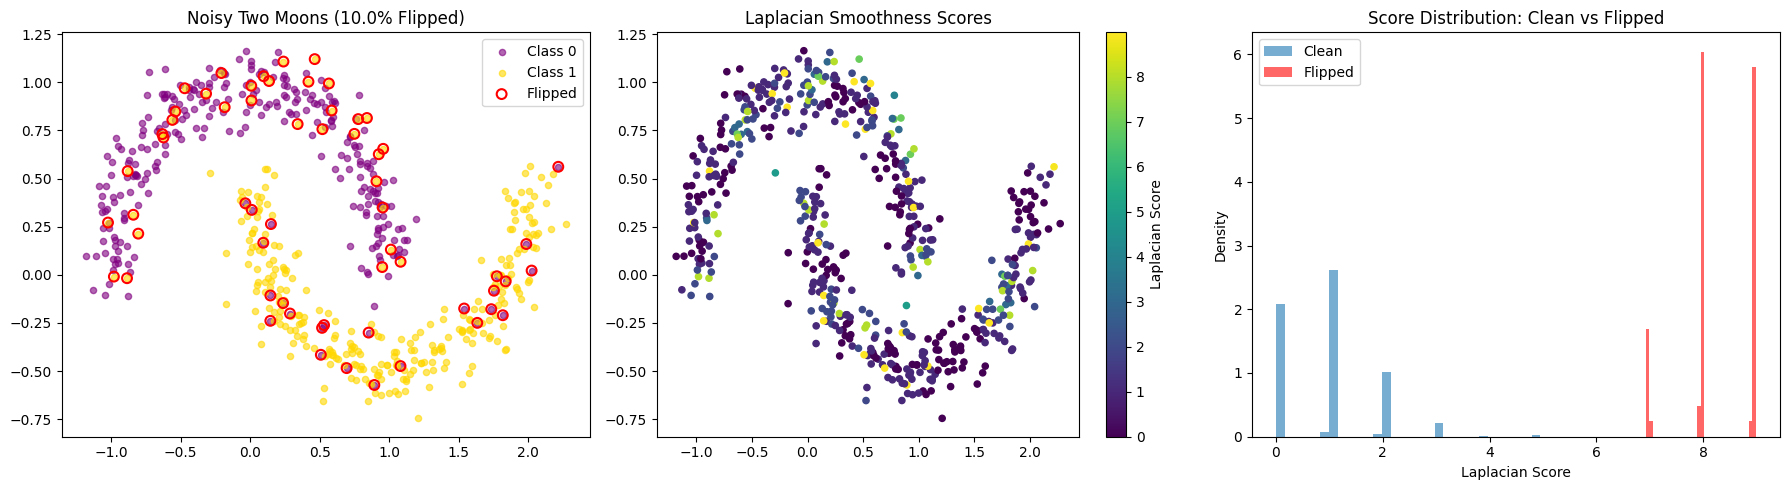

In [4]:
# Setup plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Noisy Dataset
ax = axes[0]
ax.scatter(X_train[y_train_noisy==0, 0], X_train[y_train_noisy==0, 1], c='purple', alpha=0.6, s=20, label='Class 0')
ax.scatter(X_train[y_train_noisy==1, 0], X_train[y_train_noisy==1, 1], c='gold', alpha=0.6, s=20, label='Class 1')
# Highlight flipped points
ax.scatter(X_train[is_flipped==1, 0], X_train[is_flipped==1, 1], 
           facecolors='none', edgecolors='red', s=50, linewidth=1.5, label='Flipped')
ax.set_title(f"Noisy Two Moons ({flip_ratio*100}% Flipped)")
ax.legend()

# 2. Scores Color Map
ax = axes[1]
sc = ax.scatter(X_train[:, 0], X_train[:, 1], c=scores, cmap='viridis', s=20)
plt.colorbar(sc, ax=ax, label='Laplacian Score')
ax.set_title("Laplacian Smoothness Scores")

# 3. Histogram of Scores
ax = axes[2]
ax.hist(scores[is_flipped==0], bins=30, alpha=0.6, label='Clean', density=True)
ax.hist(scores[is_flipped==1], bins=30, alpha=0.6, label='Flipped', density=True, color='red')
ax.set_title("Score Distribution: Clean vs Flipped")
ax.set_xlabel("Laplacian Score")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()

Detection AUC: 1.0000


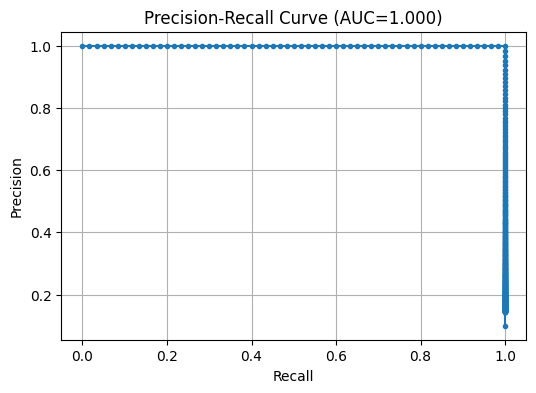

In [5]:
# Quantitative Evaluation
auc = roc_auc_score(is_flipped, scores)
print(f"Detection AUC: {auc:.4f}")

# Precision-Recall
precision, recall, _ = precision_recall_curve(is_flipped, scores)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={auc:.3f})')
plt.grid(True)
plt.show()